In [1]:
import numpy as np
import pandas as pd
from sympy import isprime
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import threading
from itertools import permutations
from numba import jit

In [2]:
cities = pd.read_csv('../input/cities.csv')
cities_len = len(cities)
print("len: ", cities_len)
cities_xy = np.stack((cities.X.values, cities.Y.values), axis=1)
cities_xy[0:5]

len:  197769


array([[ 316.83673906, 2202.34070734],
       [4377.40597217,  336.60208217],
       [3454.15819771, 2820.05301125],
       [4688.09929763, 2935.89805581],
       [1010.69695175, 3236.75098903]])

In [3]:
def get_score(path):
    xy = cities_xy[path]
    values = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)[:-1]
    prime_value = (values[9::10] * [int(isprime(i)==False)*0.1 for i in path[:-1][9::10]]).sum()
    return values.sum() + prime_value

@jit
def get_dist_values(path:np.ndarray):
    xy = cities_xy[path]
    values = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)[:-1]
    values[9::10] += values[9::10] * [int(isprime(i)==False)*0.1 for i in path[:-1][9::10]]
    return values

@jit
def get_dist_values_not_prime(path):
    xy = cities_xy[path]
    return np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)[:-1]

@jit
def get_score_not_prime(path):
    values = get_dist_values_not_prime(path)
    return values.sum()

In [4]:
#path = pd.read_csv('../input/submission_20181210.csv')
path = pd.read_csv('../input/sample_submission.csv')
path = path['Path'].values
get_score(path)

446884407.5212081

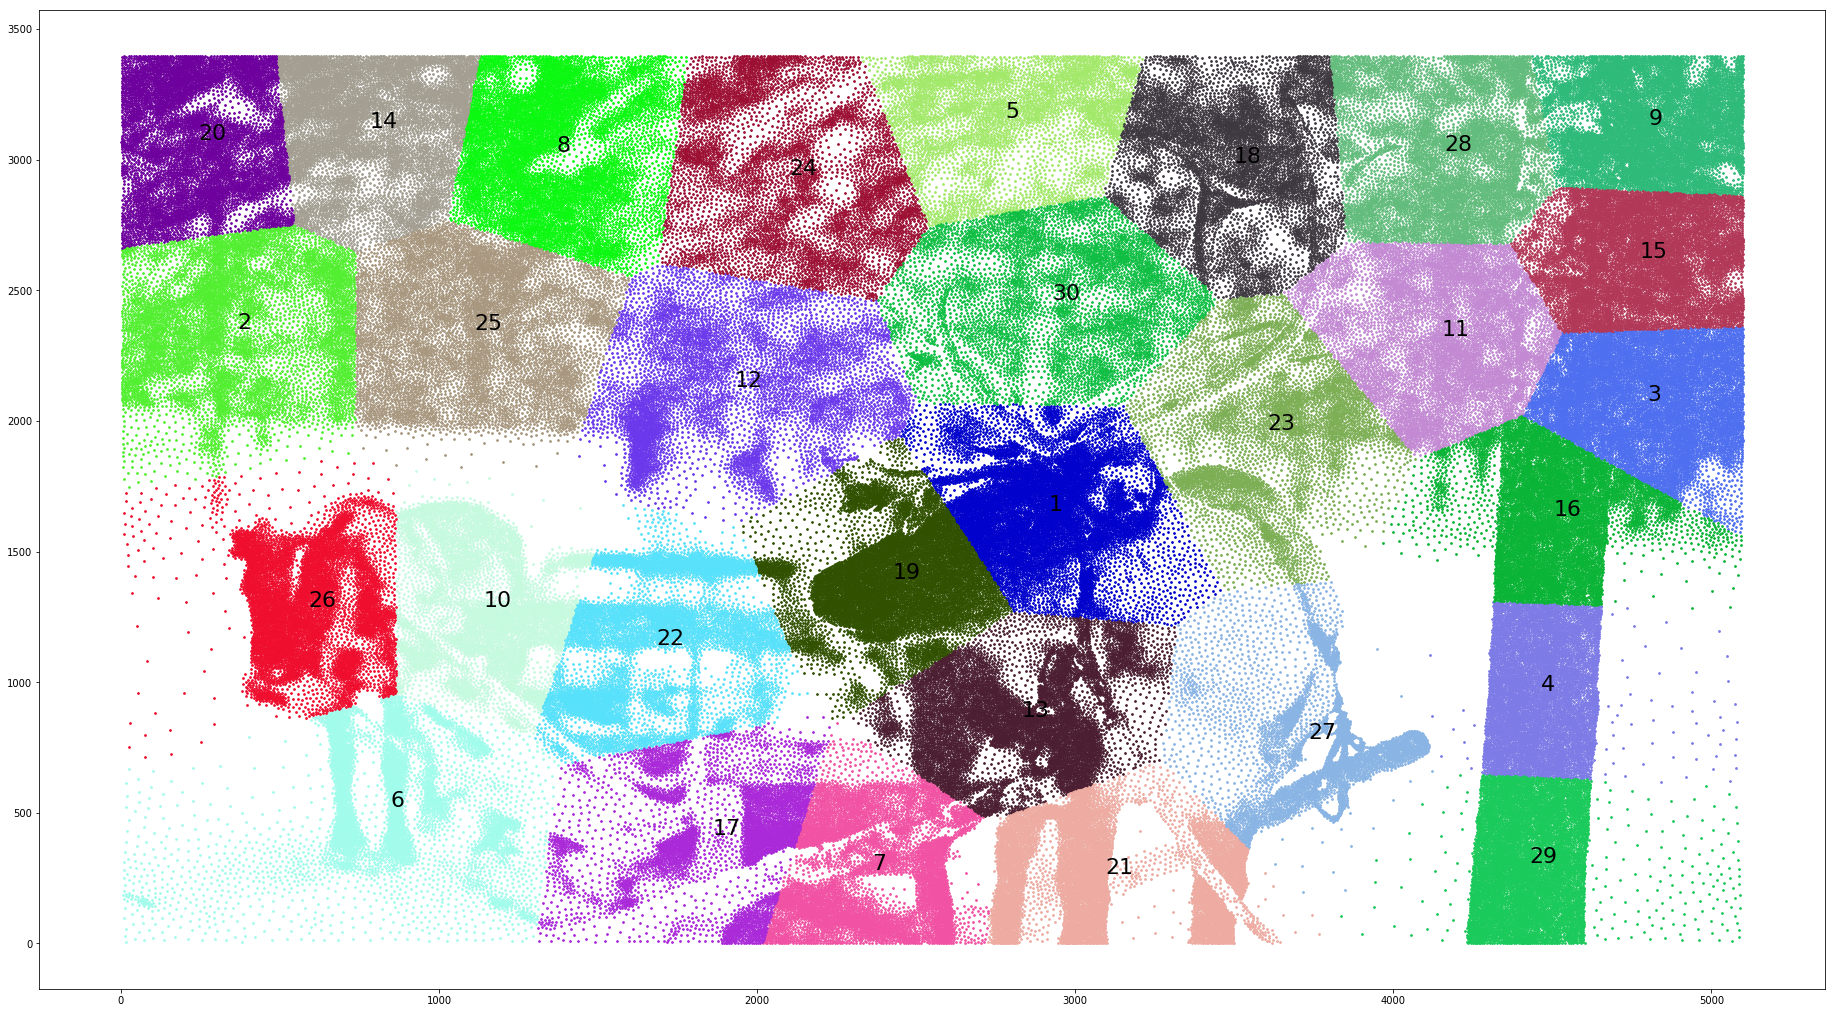

In [6]:
from sklearn.cluster import KMeans

n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters).fit(cities[['X', 'Y']])
kmeans.labels_

fig, ax = plt.subplots(figsize=(32,18))
plt.rcParams.update({'font.size': 22})
for i in range(n_clusters):
    c = [np.random.random_sample(), np.random.random_sample(), np.random.random_sample()]
    points = cities[kmeans.labels_==i]
    mean = points.mean()
    
    plt.scatter(points.X, points.Y, color=c, s=3)
    ax.annotate(str(i+1), (mean.X, mean.Y))    

In [52]:
gap_x = cities_xy[:,0].max() - cities_xy[:,0].min()
gap_y = cities_xy[:,1].max() - cities_xy[:,1].min()

@jit
def get_near_list(p:np.ndarray, pn:int)->np.ndarray:
    p_xy = cities_xy[p]
    pn_xy = cities_xy[pn] 
    r = np.sqrt(p.size/2)
    gap_xr = gap_x/r+1
    gap_yr = gap_y/r+1
    gap_p = 1
    while True:
        gap_x_value = gap_xr*gap_p
        gap_y_value = gap_yr*gap_p
        list_test = np.where((p_xy[:,0] >pn_xy[0]-gap_x_value) & 
                             (p_xy[:,0] <pn_xy[0]+gap_x_value) &
                             (p_xy[:,1] >pn_xy[1]-gap_y_value) & 
                             (p_xy[:,1] <pn_xy[1]+gap_y_value))
        if len(list_test[0]) == 0:
            gap_p += 1
        else:
            break
    return list_test[0]

@jit
def get_nearest_index(p:np.ndarray, pn:int)->np.int:
    p_xy = cities_xy[p]
    pn_xy = cities_xy[pn] 
    idx = np.linalg.norm(p_xy-pn_xy, axis=1).argmin()
    return idx

@jit
def sort_path_index(path:np.ndarray)->np.ndarray:
    xy = cities_xy[path]
    dists = np.linalg.norm(xy-cities_xy[0], axis=1)
    return np.argsort(dists)

@jit
def sort_path(path:np.ndarray)->np.ndarray:
    list_ntp = sort_path_index(path)
    return path[list_ntp]

In [54]:
@jit
def put_city_near(p:np.ndarray, pn:int)->np.ndarray:
    list_test = get_near_list(p, pn)
        
    best_k = None
    min_dist = 999999999
    for k in list_test:
        if k == 0: 
            continue

        betw = p[k-1:k+1]
        dist = get_score_not_prime(betw)
        pnn = np.insert(betw, 1, pn)
        dist_test = get_score_not_prime(pnn)
        if dist_test - dist < min_dist:
            min_dist = dist_test-dist
            best_k = k
    return np.insert(p, best_k, pn)

@jit
def put_cities_same_things()->np.ndarray:
    path = np.arange(cities_len)
    #path = np.append(np.arange(1000), [0])
    p = np.array([0,0])
    pr = path[1:]
    while pr.size != 0:
        c_index = np.random.choice(p.size)
        list_near_index = get_near_list(pr, p[c_index])
        #pr = pr[np.isin(pr, list_near) == False]
        list_near = sort_path(pr[list_near_index])
        pr = np.delete(pr, list_near_index)
        
        for pn in list_near:
            p = put_city_near(p, pn)
            
        print ('city count: {}'.format(p.size), end="\r")
    return p

#best_path = put_cities_same_things()
#print(get_score(best_path), best_path)
#1. 2321394.61246058079

In [56]:
@jit
def put_city_nearest(p:np.ndarray, pn:int)->np.ndarray:
    nearest_test_index = get_nearest_index(p, pn)
    
    best_k = None
    min_dist = 999999999
    list_test = np.array([nearest_test_index, nearest_test_index+1])
    for k in list_test:
        if k < 1: 
            continue
        betw = p[k-1:k+1]
        dist = get_score_not_prime(betw)
        #print(p, k, betw, pn)
        pnn = np.insert(betw, 1, pn)
        dist_test = get_score_not_prime(pnn)
        if dist_test - dist < min_dist:
            min_dist = dist_test-dist
            best_k = k
    return np.insert(p, best_k, pn)


@jit
def put_cities_nearest()->np.ndarray:
    path = np.arange(cities_len)
    p = np.array([0,0])
    pr = path[1:]
    while pr.size != 0:
        c_index = np.random.choice(p.size)
        nearest_index = get_nearest_index(pr, p[c_index])
        pn = pr[nearest_index]
        pr = np.delete(pr, nearest_index)
        p = put_city_nearest(p, pn)
        
        if p.size % 100 == 0:
            print ('city count: {}'.format(p.size), end="\r")
    return p

#best_path = put_cities_nearest()
#print(get_score(best_path), best_path)

In [57]:
@jit
def put_cities_sort_nearest()->np.ndarray:
    path = np.arange(cities_len)
    p = np.array([0,0])
    pr = path[1:]
    prs = sort_path(pr)
    
    for pn in prs:
        p = put_city_nearest(p, pn)
        
        if p.size%100 == 0:
            print ('city count: {}'.format(p.size), end="\r")
    return p

#best_path = put_cities_nearest2()
#print(get_score(best_path), best_path)

In [6]:
@jit
def get_nears_index(p:np.ndarray, pn:int, size:int=1)->np.int:
    p_xy = cities_xy[p]
    pn_xy = cities_xy[pn] 
    return np.argsort(np.linalg.norm(p_xy-pn_xy, axis=1))[:size]

@jit
def put_city_nears(p:np.ndarray, pn:int, near_size:int=2)->np.ndarray:
    list_test_index = get_nears_index(p, pn, near_size)
    list_test = np.unique(np.append(list_test_index, list_test_index+1))
    
    best_k = None
    min_dist = 999999999
    for k in list_test:
        if k < 1 or k > p.size-1 : 
            continue
        betw = p[k-1:k+1]
        dist = get_score_not_prime(betw)
        pnn = np.insert(betw, 1, pn)
        dist_test = get_score_not_prime(pnn)
        if dist_test - dist < min_dist:
            min_dist = dist_test - dist
            best_k = k
    return np.insert(p, best_k, pn)

@jit
def put_cities_nears(near_cnt:int=10)->np.ndarray:
    path = np.arange(cities_len)
    p = np.array([0,0])
    pr = path[1:cities_len]
    prs = sort_path(pr)
    
    for pn in prs:
        p = put_city_nears(p, pn, near_cnt)
        if p.size%100 == 0:
            print ('city count: {}'.format(p.size), end="\r")
    return p

#print("start score:", get_score(best_path))
#cities_len = 1000
best_path = put_cities_nears(20)
print("end score:", get_score(best_path), best_path)
print("unique size", np.unique(best_path).size)

end score: 1837244.8410405305 [     0 167366 139226 ...  38941  48816      0]
unique size 197769


In [7]:
path_bakup = np.copy(best_path)
path = best_path
print(get_score(path), path)
print("unique size", np.unique(path).size)

1837244.8410405305 [     0 167366 139226 ...  38941  48816      0]
unique size 197769


In [17]:
@jit
def fix_path_far_dists(path:np.ndarray, near_cnt:int=10):
    p = np.copy(path)
    
    before_dist_max = 99999999
    while True:
        xy = cities_xy[p]
        dists = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)
        #print(dists)
        dist_max = dists.max()
        dist_mean = dists.mean()
        if dist_max >= before_dist_max:
            break
        
        fars_index = np.argwhere(dists > dist_mean + (dist_max - dist_mean)*0.1 )
        pt = np.delete(p, fars_index)
        pns = p[fars_index]
        #print(fars_index.size, pt.size, pns.size)
        print ('distant city count: {}'.format(fars_index.size), end="\r")
        for pn in pns:
            pn = pn[0]
            if (pn == 0):
                continue
            
            pt = put_city_nears(pt, pn, near_cnt)
            #print(p.size, pn)
        before_dist_max = dist_max
    return pt  

print("start score:", get_score(best_path))
best_path = fix_path_far_dists(best_path, 20)
print("end score:", get_score(best_path))
print("unique size", np.unique(best_path).size)

start score: 1654208.5451685821
end score: 1656671.8376280924
unique size 197769


In [13]:
@jit
def change_city_nears(path:np.ndarray, pi:int, near_size:int=2)->np.ndarray:
    p = path
    list_test_index = get_nears_index(p, p[pi], near_size+1)
    
    k_best = None
    pi_dist = get_score_not_prime(p[pi-1:pi+2])
    min_dist = 0
    for k in list_test_index:
        if k < 1 or k > p.size-2 or k == pi: 
            continue
        
        k_dist = get_score_not_prime(p[k-1:k+2])
        p[pi], p[k] = p[k], p[pi]
        
        cpi_dist = get_score_not_prime(p[pi-1:pi+2])    
        ck_dist = get_score_not_prime(p[k-1:k+2])  
        
        p[pi], p[k] = p[k], p[pi]
        gap_dist = cpi_dist + ck_dist - pi_dist - k_dist
        if  gap_dist < min_dist:
            min_dist = gap_dist
            k_best = k
    
    if k_best is not None:
        p[pi], p[k_best] = p[k_best], p[pi]
    return p

@jit
def change_near_paths(path:np.ndarray, near_cnt:int=10):
    for i, pn in np.ndenumerate(path[1:-1]):
        pi = i[0]+1
        change_city_nears(path, pi, near_cnt)
        if pi%100 == 0:
            print ('changed city count: {}'.format(pi), end="\r")
    return path
        #break

# print("start score:", get_score(best_path))        
# change_near_paths(best_path, 20)
# print("end score:", get_score(best_path))
# print("unique size", np.unique(best_path).size)

start score: 1832105.2269338847
end score: 1744119.2452549345
unique size 197769


In [5]:
@jit
def reset_near_paths(path:np.ndarray, near_cnt:int=10):
    p = np.copy(path)
    for i in range(p.size-2):
        pi = i+1
        pn = p[pi]
        p = np.delete(p, pi)
        #print(p)
        p = put_city_nears(p, pn, near_cnt)
        #print(p)
        if pi%100 == 0:
            print ('changed city count: {}'.format(pi), end="\r")
    return p
        #break

best_path = path    
print("start score:", get_score(best_path))        
best_path = reset_near_paths(best_path, 10)
                            
print("end score:", get_score(best_path))
print("unique size", np.unique(best_path).size)

start score: 446884407.5212081


NameError: global name 'put_city_nears' is not defined

In [71]:
@jit
def fix_path_small_permutation(seq_len:int=6, band_len:int=1, start_index:int=None):
    if band_len is None:
        band_len = np.random.choice(int((cities_len-1)/seq_len)) + 1
    small_len = band_len*seq_len
    if start_index is None:
        start_index = np.random.choice(cities_len - 1 - small_len)+1
    remainder = start_index%10
    if remainder == 0:
        score_start_index = start_index - 10
    else:
        score_start_index = start_index - remainder
    end_index = start_index + small_len
    if path.size < end_index + 2:
        end_index = path.size - 1
        start_index = end_index - small_len
    small = path[start_index : end_index]
    small_start = path[score_start_index:start_index]
    small_end = path[end_index:end_index+1]
    
    small_score = path[score_start_index: end_index+1]
    score = get_score(small_score)
    if band_len > 1:
        small = small.reshape((-1,band_len))
    for item in permutations(small):
        if band_len > 1:
            item = np.concatenate(item)
        small_path_test = np.concatenate((small_start, item, small_end))
        score_test = get_score(small_path_test)
        if score_test < score:
            path[start_index : start_index + small_len] = item
            #print("path updated, score : ", get_score(path), end="\r")
            score = score_test

@jit
def fix_path_use_thread(band_len:int=None, first_index:int=None):
    seq_len = 6
    if band_len is None:
        band_len = np.random.choice(int((cities_len-1)/seq_len)) + 1
    small_len = band_len * seq_len
    if first_index is None:
        first_index = np.random.choice(small_len)
    print('band_len:', band_len, ", first_index:", first_index)    
    threads_len = int((cities_len-1)/small_len)
    threads = []
    for i in range(threads_len+2):
        if i == 0:
            start_index = 1    
        else :
            start_index = first_index + (small_len * (i-1)) + 1
        
        if start_index > cities_len:
            break
        elif start_index + small_len + 1 > cities_len:
            start_index = first_index + cities_len-small_len-1
        t = threading.Thread(target=fix_path_small_permutation, args=(seq_len, band_len, start_index))
        threads.append(t)
    for t in threads:
        t.start()
    for t in threads:
        t.join()
        
path = best_path
print("start score : ", get_score(path))
no = 1
for i in [0, 3, 0, 3]:
    fix_path_use_thread(1, i)
    print("step:", no, " score: ", get_score(path))
    no += 1
print("end score : ", get_score(path))      
print("unique size", np.unique(path).size)

start score :  1628017.6903735225
band_len: 1 , first_index: 0
step: 1  score:  1626373.7438094083
band_len: 1 , first_index: 3
step: 2  score:  1625059.85570704
band_len: 1 , first_index: 0
step: 3  score:  1624733.889212571
band_len: 1 , first_index: 3
step: 4  score:  1624600.920100777
end score :  1624600.920100777
unique size 197769


In [72]:
print("score : ", get_score(path))  
print("unique size", np.unique(path).size)

score :  1624600.920100777
unique size 197769


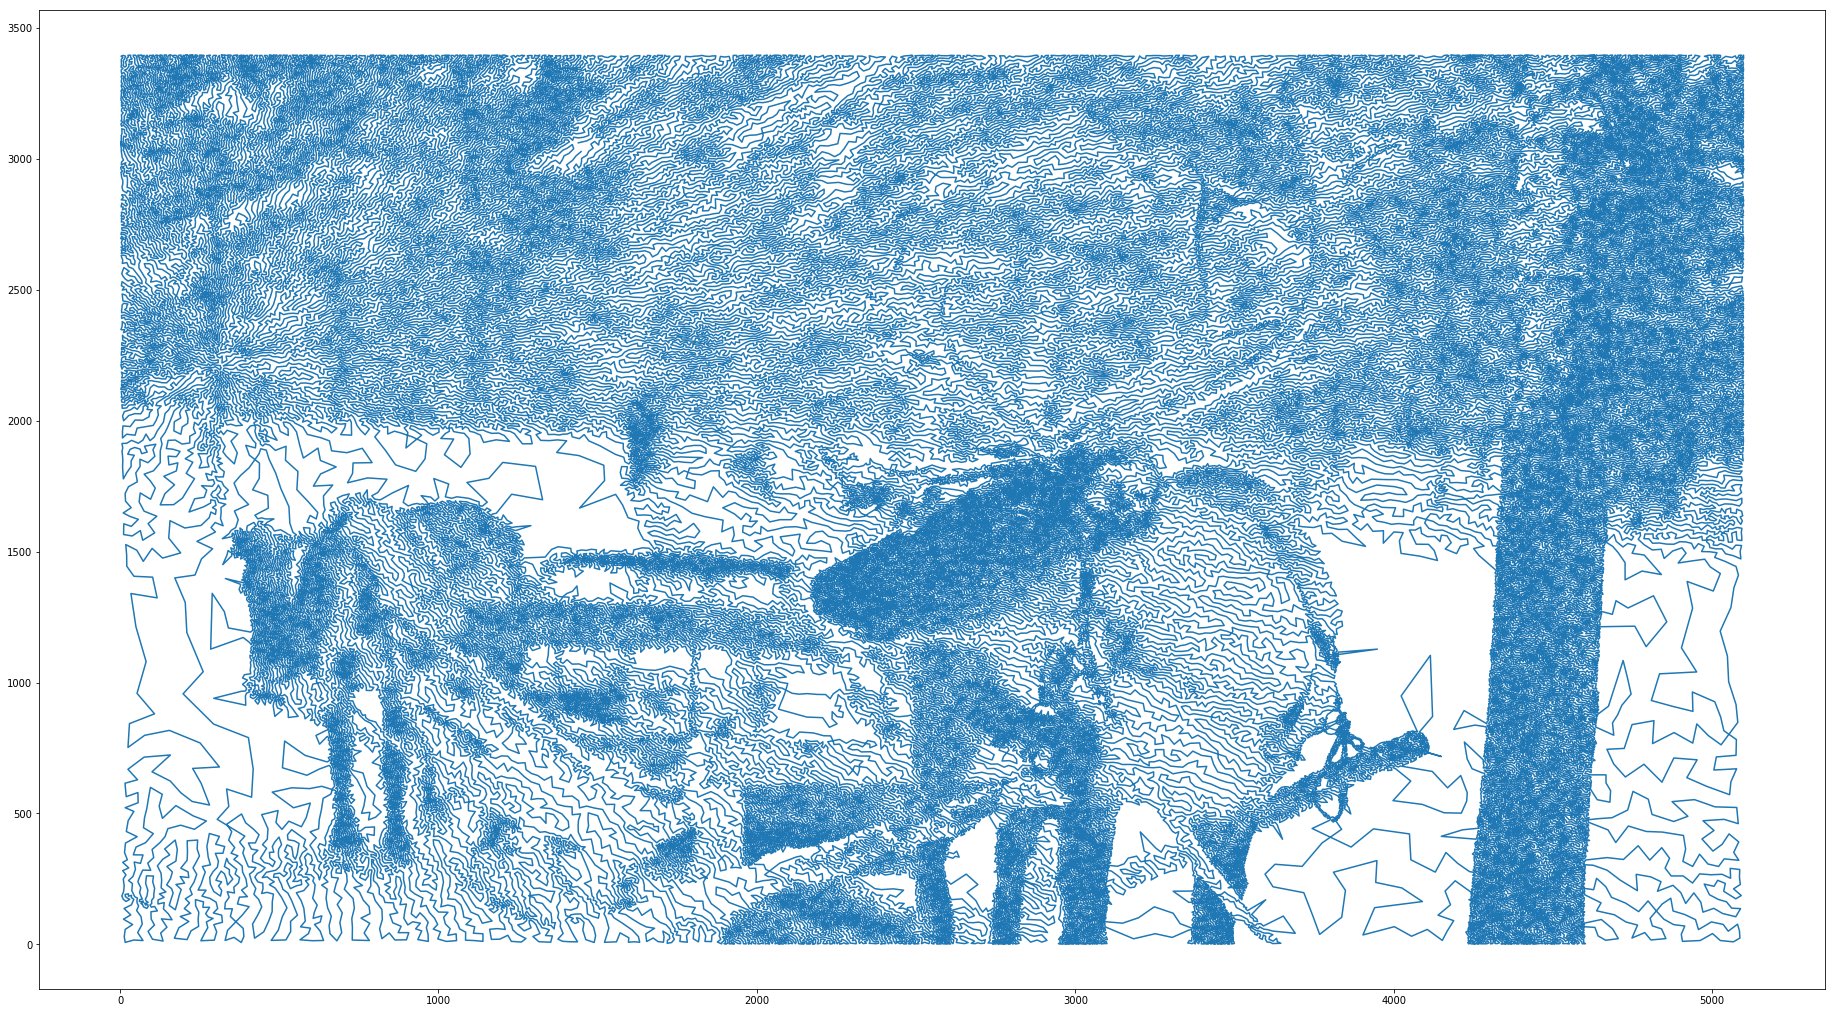

In [73]:
plt.figure(figsize=(32,18))
plt.rcParams['agg.path.chunksize'] = 10000 
plt.plot(cities.X[best_path], cities.Y[best_path])
plt.show()